[Real Time Machine Learning with Cloud Dataflow and Vertex AI](https://www.cloudskillsboost.google/focuses/3393?catalog_rank=%7B%22rank%22%3A11%2C%22num_filters%22%3A0%2C%22has_search%22%3Atrue%7D&parent=catalog&search_id=22621955)

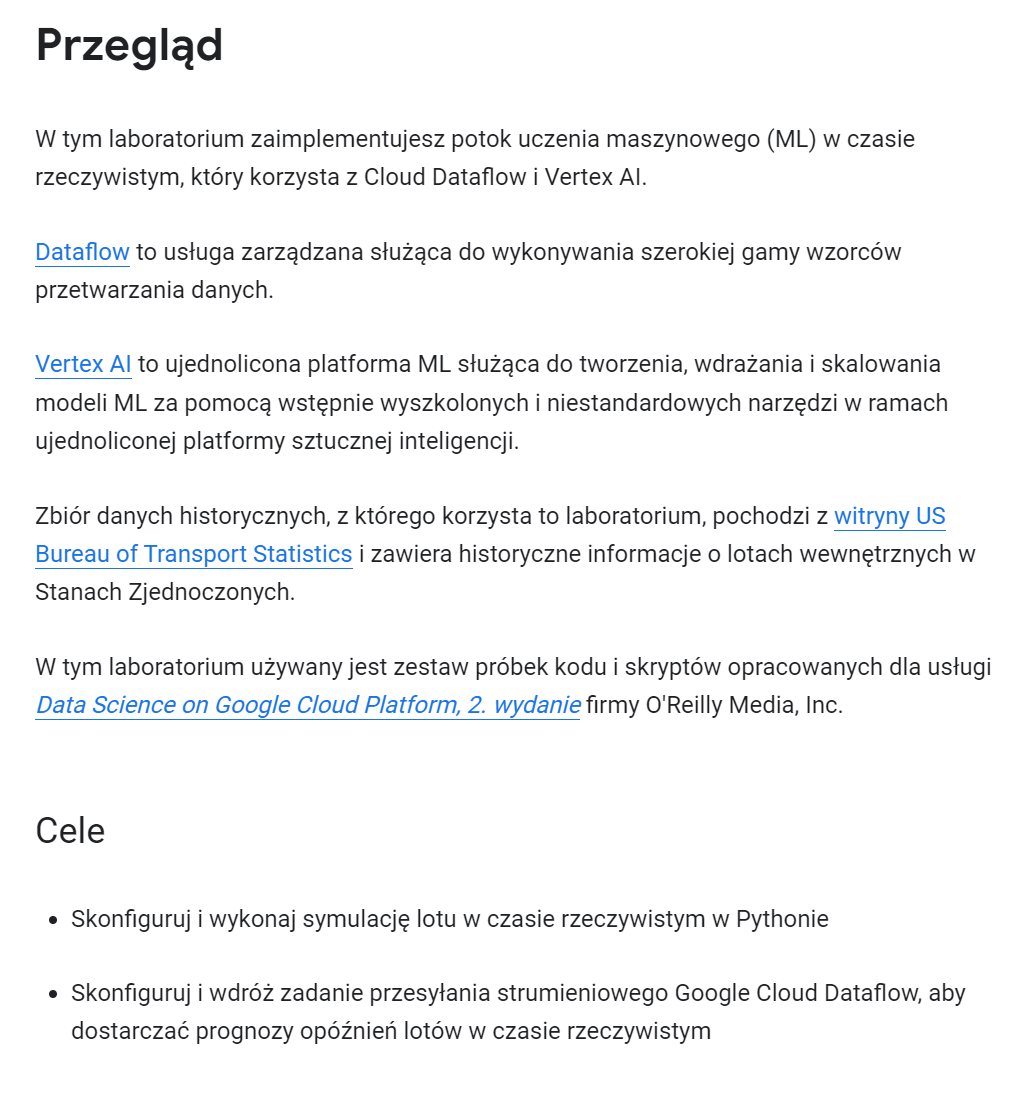

##Zadanie 1. Sklonuj repozytorium Data Science w Google Cloud

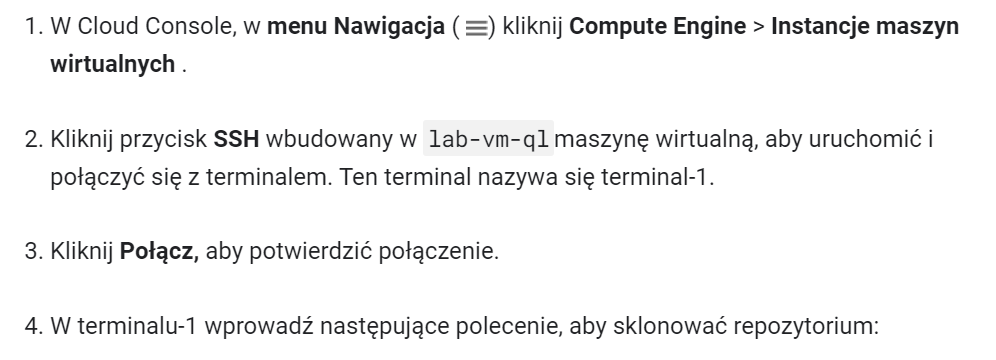

In [ ]:
git clone https://github.com/GoogleCloudPlatform/data-science-on-gcp/

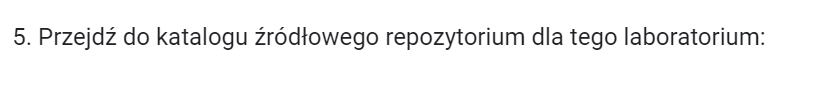

In [ ]:
cd ~/data-science-on-gcp/11_realtime

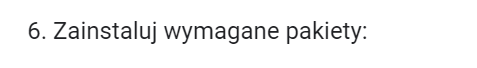

In [ ]:
pip3 install google-cloud-aiplatform cloudml-hypertune pyfarmhash tensorflow==2.8.0
pip3 install kfp 'apache-beam[gcp]'

##Zadanie 2. Zbiór danych szkoleniowych uczenia maszynowego

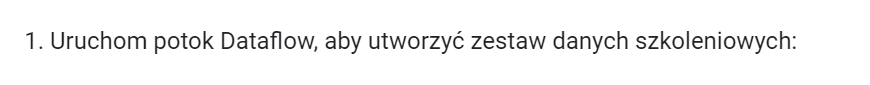

In [ ]:
export PROJECT_ID=$(gcloud info --format='value(config.project)')
export BUCKET=$PROJECT_ID-ml
python3 create_traindata.py --input bigquery --project $PROJECT_ID --bucket $BUCKET --region us-central1

####`create_traindata.py`

In [ ]:
#!/usr/bin/env python3

# Copyright 2021 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import apache_beam as beam
import logging
import os
import json

from flightstxf import flights_transforms as ftxf

CSV_HEADER = 'ontime,dep_delay,taxi_out,distance,origin,dest,dep_hour,is_weekday,carrier,dep_airport_lat,dep_airport_lon,arr_airport_lat,arr_airport_lon,avg_dep_delay,avg_taxi_out,data_split'


def dict_to_csv(f):
    try:
        yield ','.join([str(x) for x in f.values()])
    except Exception as e:
        logging.warning('Ignoring {} because: {}'.format(f, e), exc_info=True)
        pass


def run(project, bucket, region, input):
    if input == 'local':
        logging.info('Running locally on small extract')
        argv = [
            '--runner=DirectRunner'
        ]
        flights_output = '/tmp/'
    else:
        logging.info('Running in the cloud on full dataset input={}'.format(input))
        argv = [
            '--project={0}'.format(project),
            '--job_name=ch11traindata',
            # '--save_main_session', # not needed as we are running as a package now
            '--staging_location=gs://{0}/flights/staging/'.format(bucket),
            '--temp_location=gs://{0}/flights/temp/'.format(bucket),
            '--setup_file=./setup.py',
            '--autoscaling_algorithm=THROUGHPUT_BASED',
            '--max_num_workers=20',
            # '--max_num_workers=4', '--worker_machine_type=m1-ultramem-40', '--disk_size_gb=500',  # for full 2015-2019 dataset
            '--region={}'.format(region),
            '--runner=DataflowRunner'
        ]
        flights_output = 'gs://{}/ch11/data/'.format(bucket)

    with beam.Pipeline(argv=argv) as pipeline:

        # read the event stream
        if input == 'local':
            input_file = './alldata_sample.json'
            logging.info("Reading from {} ... Writing to {}".format(input_file, flights_output))
            events = (
                    pipeline
                    | 'read_input' >> beam.io.ReadFromText(input_file)
                    | 'parse_input' >> beam.Map(lambda line: json.loads(line))
            )
        elif input == 'bigquery':
            input_table = 'dsongcp.flights_tzcorr'
            logging.info("Reading from {} ... Writing to {}".format(input_table, flights_output))
            events = (
                    pipeline
                    | 'read_input' >> beam.io.ReadFromBigQuery(table=input_table)
            )
        else:
            logging.error("Unknown input type {}".format(input))
            return

        # events -> features.  See ./flights_transforms.py for the code shared between training & prediction
        features = ftxf.transform_events_to_features(events)

        # shuffle globally so that we are not at mercy of TensorFlow's shuffle buffer
        features = (
            features
            | 'into_global' >> beam.WindowInto(beam.window.GlobalWindows())
            | 'shuffle' >> beam.util.Reshuffle()
        )

        # write out
        for split in ['ALL', 'TRAIN', 'VALIDATE', 'TEST']:
            feats = features
            if split != 'ALL':
                feats = feats | 'only_{}'.format(split) >> beam.Filter(lambda f: f['data_split'] == split)
            (
                feats
                | '{}_to_string'.format(split) >> beam.FlatMap(dict_to_csv)
                | '{}_to_gcs'.format(split) >> beam.io.textio.WriteToText(os.path.join(flights_output, split.lower()),
                                                                          file_name_suffix='.csv', header=CSV_HEADER,
                                                                          # workaround b/207384805
                                                                          num_shards=1)
            )


if __name__ == '__main__':
    import argparse

    parser = argparse.ArgumentParser(description='Create training CSV file that includes time-aggregate features')
    parser.add_argument('-p', '--project', help='Project to be billed for Dataflow job. Omit if running locally.')
    parser.add_argument('-b', '--bucket', help='Training data will be written to gs://BUCKET/flights/ch11/')
    parser.add_argument('-r', '--region', help='Region to run Dataflow job. Choose the same region as your bucket.')
    parser.add_argument('-i', '--input', help='local OR bigquery', required=True)

    logging.getLogger().setLevel(logging.INFO)
    args = vars(parser.parse_args())

    if args['input'] != 'local':
        if not args['bucket'] or not args['project'] or not args['region']:
            print("Project, Bucket, Region are needed in order to run on the cloud on full dataset.")
            parser.print_help()
            parser.exit()

    run(project=args['project'], bucket=args['bucket'], region=args['region'], input=args['input'])

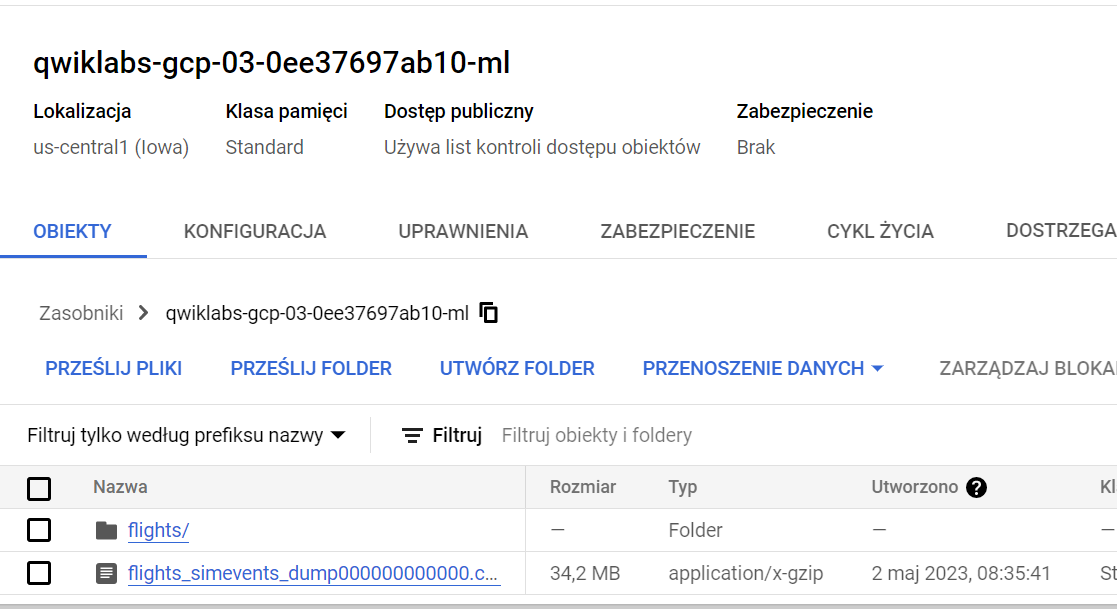

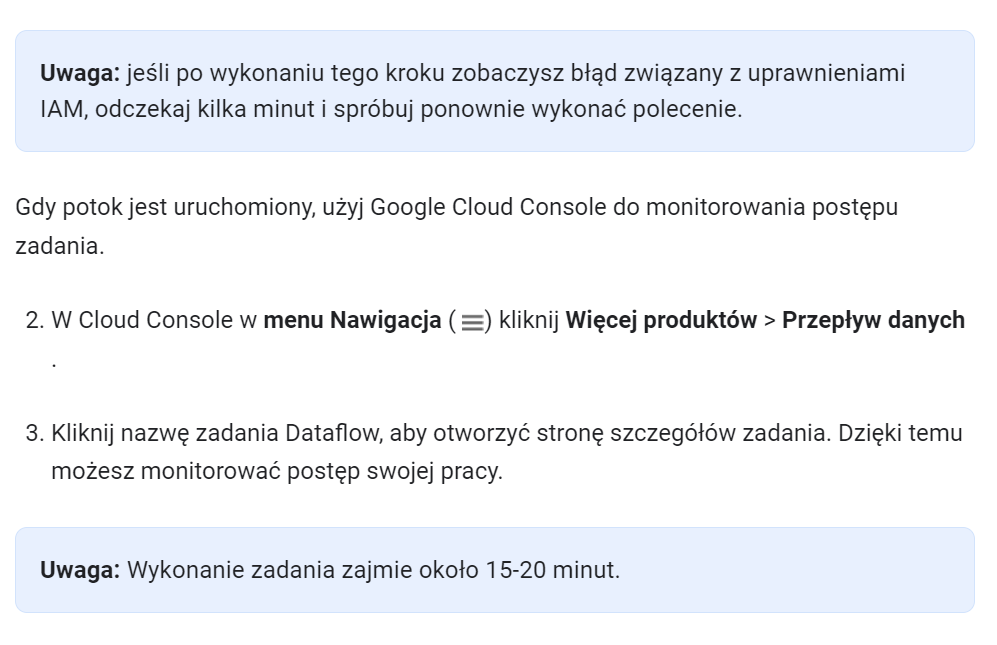

##Zadanie 3. Wytrenuj model

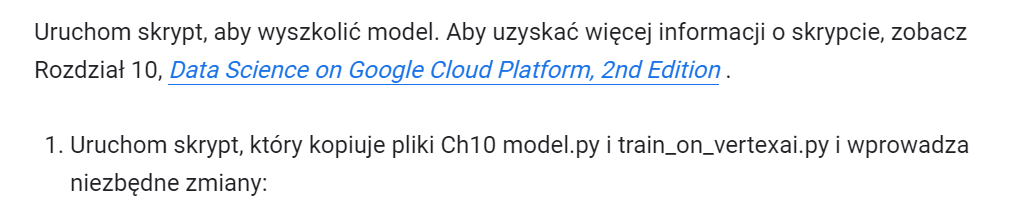

In [ ]:
# https://www.oreilly.com/library/view/data-science-on/9781098118945/

In [ ]:
python3 change_ch10_files.py

###`model.py`

In [ ]:
# Copyright 2017-2021 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import argparse
import logging
import os, time
import hypertune
import numpy as np
import tensorflow as tf

BUCKET = None
TF_VERSION = '2-' + tf.__version__[2:3]  # needed to choose container

DEVELOP_MODE = True
NUM_EXAMPLES = 5000 * 1000  # doesn't need to be precise but get order of magnitude right.

NUM_BUCKETS = 5
NUM_EMBEDS = 3
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

CSV_COLUMNS = (
    'ontime,dep_delay,taxi_out,distance,origin,dest,dep_hour,is_weekday,carrier,' +
    'dep_airport_lat,dep_airport_lon,arr_airport_lat,arr_airport_lon,data_split'
).split(',')

CSV_COLUMN_TYPES = [
    1.0, -3.0, 5.0, 1037.493622678299, 'OTH', 'DEN', 21, 1.0, 'OO',
    43.41694444, -124.24694444, 39.86166667, -104.67305556, 'TRAIN'
]


def features_and_labels(features):
    label = features.pop('ontime')  # this is what we will train for
    return features, label


def read_dataset(pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN, truncate=None):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=CSV_COLUMN_TYPES,
        sloppy=True,
        num_parallel_reads=2,
        ignore_errors=True,
        num_epochs=1)
    dataset = dataset.map(features_and_labels)
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(batch_size * 10)
        dataset = dataset.repeat()
    dataset = dataset.prefetch(1)
    if truncate is not None:
        dataset = dataset.take(truncate)
    return dataset


def create_model():
    real = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in
        (
                'dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
                'dep_airport_lat,dep_airport_lon,' +
                'arr_airport_lat,arr_airport_lon'
        ).split(',')
    }
    sparse = {
        'carrier': tf.feature_column.categorical_column_with_vocabulary_list('carrier',
                                                                             vocabulary_list='AS,VX,F9,UA,US,WN,HA,EV,MQ,DL,OO,B6,NK,AA'.split(
                                                                                 ',')),
        'origin': tf.feature_column.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
        'dest': tf.feature_column.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000),
    }

    inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
        for colname in real.keys()
    }
    inputs.update({
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype='string')
        for colname in sparse.keys()
    })

    latbuckets = np.linspace(20.0, 50.0, NUM_BUCKETS).tolist()  # USA
    lonbuckets = np.linspace(-120.0, -70.0, NUM_BUCKETS).tolist()  # USA
    disc = {}
    disc.update({
        'd_{}'.format(key): tf.feature_column.bucketized_column(real[key], latbuckets)
        for key in ['dep_airport_lat', 'arr_airport_lat']
    })
    disc.update({
        'd_{}'.format(key): tf.feature_column.bucketized_column(real[key], lonbuckets)
        for key in ['dep_airport_lon', 'arr_airport_lon']
    })

    # cross columns that make sense in combination
    sparse['dep_loc'] = tf.feature_column.crossed_column(
        [disc['d_dep_airport_lat'], disc['d_dep_airport_lon']], NUM_BUCKETS * NUM_BUCKETS)
    sparse['arr_loc'] = tf.feature_column.crossed_column(
        [disc['d_arr_airport_lat'], disc['d_arr_airport_lon']], NUM_BUCKETS * NUM_BUCKETS)
    sparse['dep_arr'] = tf.feature_column.crossed_column([sparse['dep_loc'], sparse['arr_loc']], NUM_BUCKETS ** 4)

    # embed all the sparse columns
    embed = {
        'embed_{}'.format(colname): tf.feature_column.embedding_column(col, NUM_EMBEDS)
        for colname, col in sparse.items()
    }
    real.update(embed)

    # one-hot encode the sparse columns
    sparse = {
        colname: tf.feature_column.indicator_column(col)
        for colname, col in sparse.items()
    }

    model = wide_and_deep_classifier(
        inputs,
        linear_feature_columns=sparse.values(),
        dnn_feature_columns=real.values(),
        dnn_hidden_units=DNN_HIDDEN_UNITS)

    return model


def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno + 1))(deep)
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', rmse, tf.keras.metrics.AUC()])
    return model


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def train_and_evaluate(train_data_pattern, eval_data_pattern, test_data_pattern, export_dir, output_dir):
    train_batch_size = TRAIN_BATCH_SIZE
    if DEVELOP_MODE:
        eval_batch_size = 100
        steps_per_epoch = 3
        epochs = 2
        num_eval_examples = eval_batch_size * 10
    else:
        eval_batch_size = 100
        steps_per_epoch = NUM_EXAMPLES // train_batch_size
        epochs = NUM_EPOCHS
        num_eval_examples = eval_batch_size * 100

    train_dataset = read_dataset(train_data_pattern, train_batch_size)
    eval_dataset = read_dataset(eval_data_pattern, eval_batch_size, tf.estimator.ModeKeys.EVAL, num_eval_examples)

    # checkpoint
    checkpoint_path = '{}/checkpoints/flights.cpt'.format(output_dir)
    logging.info("Checkpointing to {}".format(checkpoint_path))
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    # call back to write out hyperparameter tuning metric
    METRIC = 'val_rmse'
    hpt = hypertune.HyperTune()

    class HpCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs and METRIC in logs:
                logging.info("Epoch {}: {} = {}".format(epoch, METRIC, logs[METRIC]))
                hpt.report_hyperparameter_tuning_metric(hyperparameter_metric_tag=METRIC,
                                                        metric_value=logs[METRIC],
                                                        global_step=epoch)

    # train the model
    model = create_model()
    logging.info(f"Training on {train_data_pattern}; eval on {eval_data_pattern}; {epochs} epochs; {steps_per_epoch}")
    history = model.fit(train_dataset,
                        validation_data=eval_dataset,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        callbacks=[cp_callback, HpCallback()])

    # export
    logging.info('Exporting to {}'.format(export_dir))
    tf.saved_model.save(model, export_dir)

    # write out final metric
    final_rmse = history.history[METRIC][-1]
    logging.info("Validation metric {} on {} samples = {}".format(METRIC, num_eval_examples, final_rmse))

    if (not DEVELOP_MODE) and (test_data_pattern is not None) and (not SKIP_FULL_EVAL):
        logging.info("Evaluating over full test dataset")
        test_dataset = read_dataset(test_data_pattern, eval_batch_size, tf.estimator.ModeKeys.EVAL, None)
        final_metrics = model.evaluate(test_dataset)
        logging.info("Final metrics on full test dataset = {}".format(final_metrics))
    else:
        logging.info("Skipping evaluation on full test dataset")


if __name__ == '__main__':
    logging.info("Tensorflow version " + tf.__version__)
    parser = argparse.ArgumentParser()

    parser.add_argument(
        '--bucket',
        help='Data will be read from gs://BUCKET/ch9/data and output will be in gs://BUCKET/ch9/trained_model',
        required=True
    )

    parser.add_argument(
        '--num_examples',
        help='Number of examples per epoch. Get order of magnitude correct.',
        type=int,
        default=5000000
    )

    # for hyper-parameter tuning
    parser.add_argument(
        '--train_batch_size',
        help='Number of examples to compute gradient on',
        type=int,
        default=256  # originally 64
    )
    parser.add_argument(
        '--nbuckets',
        help='Number of bins into which to discretize lats and lons',
        type=int,
        default=10  # originally 5
    )
    parser.add_argument(
        '--nembeds',
        help='Embedding dimension for categorical variables',
        type=int,
        default=3
    )
    parser.add_argument(
        '--num_epochs',
        help='Number of epochs (used only if --develop is not set)',
        type=int,
        default=10
    )
    parser.add_argument(
        '--dnn_hidden_units',
        help='Architecture of DNN part of wide-and-deep network',
        default='64,64,64,8'  # originally '64,32'
    )
    parser.add_argument(
        '--develop',
        help='Train on a small subset in development',
        dest='develop',
        action='store_true')
    parser.set_defaults(develop=False)
    parser.add_argument(
        '--skip_full_eval',
        help='Just train. Do not evaluate on test dataset.',
        dest='skip_full_eval',
        action='store_true')
    parser.set_defaults(skip_full_eval=False)

    # parse args
    args = parser.parse_args().__dict__
    logging.getLogger().setLevel(logging.INFO)

    # The Vertex AI contract. If not running in Vertex AI Training, these will be None
    OUTPUT_MODEL_DIR = os.getenv("AIP_MODEL_DIR")  # or None
    TRAIN_DATA_PATTERN = os.getenv("AIP_TRAINING_DATA_URI")
    EVAL_DATA_PATTERN = os.getenv("AIP_VALIDATION_DATA_URI")
    TEST_DATA_PATTERN = os.getenv("AIP_TEST_DATA_URI")

    # set top-level output directory for checkpoints, etc.
    BUCKET = args['bucket']
    OUTPUT_DIR = 'gs://{}/ch9/train_output'.format(BUCKET)
    # During hyperparameter tuning, we need to make sure different trials don't clobber each other
    # https://cloud.google.com/ai-platform/training/docs/distributed-training-details#tf-config-format
    # This doesn't exist in Vertex AI
    # OUTPUT_DIR = os.path.join(
    #     OUTPUT_DIR,
    #     json.loads(
    #         os.environ.get('TF_CONFIG', '{}')
    #     ).get('task', {}).get('trial', '')
    # )
    if OUTPUT_MODEL_DIR:
        # convert gs://ai-analytics-solutions-dsongcp2/aiplatform-custom-job-2021-11-13-22:22:46.175/1/model/
        # to gs://ai-analytics-solutions-dsongcp2/aiplatform-custom-job-2021-11-13-22:22:46.175/1
        OUTPUT_DIR = os.path.join(
            os.path.dirname(OUTPUT_MODEL_DIR if OUTPUT_MODEL_DIR[-1] != '/' else OUTPUT_MODEL_DIR[:-1]),
            'train_output')
    logging.info('Writing checkpoints and other outputs to {}'.format(OUTPUT_DIR))

    # Set default values for the contract variables in case we are not running in Vertex AI Training
    if not OUTPUT_MODEL_DIR:
        OUTPUT_MODEL_DIR = os.path.join(OUTPUT_DIR,
                                        'export/flights_{}'.format(time.strftime("%Y%m%d-%H%M%S")))
    if not TRAIN_DATA_PATTERN:
        TRAIN_DATA_PATTERN = 'gs://{}/ch9/data/train*'.format(BUCKET)
        CSV_COLUMNS.pop()  # the data_split column won't exist
        CSV_COLUMN_TYPES.pop()  # the data_split column won't exist
    if not EVAL_DATA_PATTERN:
        EVAL_DATA_PATTERN = 'gs://{}/ch9/data/eval*'.format(BUCKET)
    logging.info('Exporting trained model to {}'.format(OUTPUT_MODEL_DIR))
    logging.info("Reading training data from {}".format(TRAIN_DATA_PATTERN))
    logging.info('Writing trained model to {}'.format(OUTPUT_MODEL_DIR))

    # other global parameters
    NUM_BUCKETS = args['nbuckets']
    NUM_EMBEDS = args['nembeds']
    NUM_EXAMPLES = args['num_examples']
    NUM_EPOCHS = args['num_epochs']
    TRAIN_BATCH_SIZE = args['train_batch_size']
    DNN_HIDDEN_UNITS = args['dnn_hidden_units']
    DEVELOP_MODE = args['develop']
    SKIP_FULL_EVAL = args['skip_full_eval']

    # run
    train_and_evaluate(TRAIN_DATA_PATTERN, EVAL_DATA_PATTERN, TEST_DATA_PATTERN, OUTPUT_MODEL_DIR, OUTPUT_DIR)

    logging.info("Done")

###`train_on_vertexai.py`

In [ ]:
# Copyright 2017-2021 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import argparse
import logging
from datetime import datetime
import tensorflow as tf

from google.cloud import aiplatform
from google.cloud.aiplatform import gapic as aip
from google.cloud.aiplatform import hyperparameter_tuning as hpt
from kfp.v2 import compiler, dsl

ENDPOINT_NAME = 'flights'


def train_custom_model(data_set, timestamp, develop_mode, cpu_only_mode, tf_version, extra_args=None):
    # Set up training and deployment infra

    if cpu_only_mode:
        train_image='us-docker.pkg.dev/vertex-ai/training/tf-cpu.{}:latest'.format(tf_version)
        deploy_image='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.{}:latest'.format(tf_version)
    else:
        train_image = "us-docker.pkg.dev/vertex-ai/training/tf-gpu.{}:latest".format(tf_version)
        deploy_image = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.{}:latest".format(tf_version)

    # train
    model_display_name = '{}-{}'.format(ENDPOINT_NAME, timestamp)
    job = aiplatform.CustomTrainingJob(
        display_name='train-{}'.format(model_display_name),
        script_path="model.py",
        container_uri=train_image,
        requirements=['cloudml-hypertune'],  # any extra Python packages
        model_serving_container_image_uri=deploy_image
    )
    model_args = [
        '--bucket', BUCKET,
    ]
    if develop_mode:
        model_args += ['--develop']
    if extra_args:
        model_args += extra_args

    if cpu_only_mode:
        model = job.run(
            dataset=data_set,
            # See https://googleapis.dev/python/aiplatform/latest/aiplatform.html#
            predefined_split_column_name='data_split',
            model_display_name=model_display_name,
            args=model_args,
            replica_count=1,
            machine_type='n1-standard-4',
            sync=develop_mode
        )
    else:
        model = job.run(
            dataset=data_set,
            # See https://googleapis.dev/python/aiplatform/latest/aiplatform.html#
            predefined_split_column_name='data_split',
            model_display_name=model_display_name,
            args=model_args,
            replica_count=1,
            machine_type='n1-standard-4',
            # See https://cloud.google.com/vertex-ai/docs/general/locations#accelerators
            accelerator_type=aip.AcceleratorType.NVIDIA_TESLA_T4.name,
            accelerator_count=1,
            sync=develop_mode
        )
    return model


def train_automl_model(data_set, timestamp, develop_mode):
    # train
    model_display_name = '{}-{}'.format(ENDPOINT_NAME, timestamp)
    job = aiplatform.AutoMLTabularTrainingJob(
        display_name='train-{}'.format(model_display_name),
        optimization_prediction_type='classification'
    )
    model = job.run(
        dataset=data_set,
        # See https://googleapis.dev/python/aiplatform/latest/aiplatform.html#
        predefined_split_column_name='data_split',
        target_column='ontime',
        model_display_name=model_display_name,
        budget_milli_node_hours=(300 if develop_mode else 2000),
        disable_early_stopping=False,
        export_evaluated_data_items=True,
        export_evaluated_data_items_bigquery_destination_uri='{}:dsongcp.ch9_automl_evaluated'.format(PROJECT),
        export_evaluated_data_items_override_destination=True,
        sync=develop_mode
    )
    return model


def do_hyperparameter_tuning(data_set, timestamp, develop_mode, cpu_only_mode, tf_version):
    # Vertex AI services require regional API endpoints.
    if cpu_only_mode:
        train_image='us-docker.pkg.dev/vertex-ai/training/tf-cpu.{}:latest'.format(tf_version)
    else:
        train_image = "us-docker.pkg.dev/vertex-ai/training/tf-gpu.{}:latest".format(tf_version)

    # a single trial job
    model_display_name = '{}-{}'.format(ENDPOINT_NAME, timestamp)
    if cpu_only_mode:
        trial_job = aiplatform.CustomJob.from_local_script(
            display_name='train-{}'.format(model_display_name),
            script_path="model.py",
            container_uri=train_image,
            args=[
                '--bucket', BUCKET,
                '--skip_full_eval',  # no need to evaluate on test data set
                '--num_epochs', '10',
                '--num_examples', '500000'  # 1/10 actual size to finish faster
            ],
            requirements=['cloudml-hypertune'],  # any extra Python packages
            replica_count=1,
            machine_type='n1-standard-4'
        )
    else:
        trial_job = aiplatform.CustomJob.from_local_script(
            display_name='train-{}'.format(model_display_name),
            script_path="model.py",
            container_uri=train_image,
            args=[
                '--bucket', BUCKET,
                '--skip_full_eval',  # no need to evaluate on test data set
                '--num_epochs', '10',
                '--num_examples', '500000'  # 1/10 actual size to finish faster
            ],
            requirements=['cloudml-hypertune'],  # any extra Python packages
            replica_count=1,
            machine_type='n1-standard-4',
            # See https://cloud.google.com/vertex-ai/docs/general/locations#accelerators
            accelerator_type=aip.AcceleratorType.NVIDIA_TESLA_T4.name,
            accelerator_count=1,
        )

    # the tuning job
    hparam_job = aiplatform.HyperparameterTuningJob(
        # See https://googleapis.dev/python/aiplatform/latest/aiplatform.html#
        display_name='hparam-{}'.format(model_display_name),
        custom_job=trial_job,
        metric_spec={'val_rmse': 'minimize'},
        parameter_spec={
            "train_batch_size": hpt.IntegerParameterSpec(min=16, max=256, scale='log'),
            "nbuckets": hpt.IntegerParameterSpec(min=5, max=10, scale='linear'),
            "dnn_hidden_units": hpt.CategoricalParameterSpec(values=["64,16", "64,16,4", "64,64,64,8", "256,64,16"])
        },
        max_trial_count=2 if develop_mode else NUM_HPARAM_TRIALS,
        parallel_trial_count=2,
        search_algorithm=None,  # Bayesian
    )

    hparam_job.run(sync=True)  # has to finish before we can get trials.

    # get the parameters corresponding to the best trial
    best = sorted(hparam_job.trials, key=lambda x: x.final_measurement.metrics[0].value)[0]
    logging.info('Best trial: {}'.format(best))
    best_params = []
    for param in best.parameters:
        best_params.append('--{}'.format(param.parameter_id))

        if param.parameter_id in ["train_batch_size", "nbuckets"]:
            # hparam returns 10.0 even though it's an integer param. so round it.
            # but CustomTrainingJob makes integer args into floats. so make it a string
            best_params.append(str(int(round(param.value))))
        else:
            # string or float parameters
            best_params.append(param.value)

    # run the best trial to completion
    logging.info('Launching full training job with {}'.format(best_params))
    return train_custom_model(data_set, timestamp, develop_mode, cpu_only_mode, tf_version, extra_args=best_params)


@dsl.pipeline(name="flights-ch9-pipeline",
              description="ds-on-gcp ch9 flights pipeline"
)
def main():
    aiplatform.init(project=PROJECT, location=REGION, staging_bucket='gs://{}'.format(BUCKET))

    # create data set
    all_files = tf.io.gfile.glob('gs://{}/ch9/data/all*.csv'.format(BUCKET))
    logging.info("Training on {}".format(all_files))
    data_set = aiplatform.TabularDataset.create(
        display_name='data-{}'.format(ENDPOINT_NAME),
        gcs_source=all_files
    )
    if TF_VERSION is not None:
        tf_version = TF_VERSION.replace(".", "-")
    else:
        tf_version = '2-' + tf.__version__[2:3]

    # train
    if AUTOML:
        model = train_automl_model(data_set, TIMESTAMP, DEVELOP_MODE)
    elif NUM_HPARAM_TRIALS > 1:
        model = do_hyperparameter_tuning(data_set, TIMESTAMP, DEVELOP_MODE, CPU_ONLY_MODE, tf_version)
    else:
        model = train_custom_model(data_set, TIMESTAMP, DEVELOP_MODE, CPU_ONLY_MODE, tf_version)

    # create endpoint if it doesn't already exist
    endpoints = aiplatform.Endpoint.list(
        filter='display_name="{}"'.format(ENDPOINT_NAME),
        order_by='create_time desc',
        project=PROJECT, location=REGION,
    )
    if len(endpoints) > 0:
        endpoint = endpoints[0]  # most recently created
    else:
        endpoint = aiplatform.Endpoint.create(
            display_name=ENDPOINT_NAME, project=PROJECT, location=REGION,
            sync=DEVELOP_MODE
        )

    # deploy
    model.deploy(
        endpoint=endpoint,
        traffic_split={"0": 100},
        machine_type='n1-standard-2',
        min_replica_count=1,
        max_replica_count=1,
        sync=DEVELOP_MODE
    )

    if DEVELOP_MODE:
        model.wait()


def run_pipeline():
    compiler.Compiler().compile(pipeline_func=main, package_path='flights_pipeline.json')

    job = aip.PipelineJob(
        display_name="{}-pipeline".format(ENDPOINT_NAME),
        template_path="{}_pipeline.json".format(ENDPOINT_NAME),
        pipeline_root="{}/pipeline_root/intro".format(BUCKET),
        enable_caching=False
    )

    job.run()


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    parser.add_argument(
        '--bucket',
        help='Data will be read from gs://BUCKET/ch9/data and checkpoints will be in gs://BUCKET/ch9/trained_model',
        required=True
    )
    parser.add_argument(
        '--region',
        help='Where to run the trainer',
        default='us-central1'
    )
    parser.add_argument(
        '--project',
        help='Project to be billed',
        required=True
    )
    parser.add_argument(
        '--develop',
        help='Train on a small subset in development',
        dest='develop',
        action='store_true')
    parser.set_defaults(develop=False)
    parser.add_argument(
        '--automl',
        help='Train an AutoML Table, instead of using model.py',
        dest='automl',
        action='store_true')
    parser.set_defaults(automl=False)
    parser.add_argument(
        '--num_hparam_trials',
        help='Number of hyperparameter trials. 0/1 means no hyperparam. Ignored if --automl is set.',
        type=int,
        default=0)
    parser.add_argument(
        '--pipeline',
        help='Run as pipeline',
        dest='pipeline',
        action='store_true')
    parser.add_argument(
        '--cpuonly',
        help='Run without GPU',
        dest='cpuonly',
        action='store_true')
    parser.set_defaults(cpuonly=False)
    parser.add_argument(
        '--tfversion',
        help='TensorFlow version to use'
    )

    # parse args
    logging.getLogger().setLevel(logging.INFO)
    args = parser.parse_args().__dict__
    BUCKET = args['bucket']
    PROJECT = args['project']
    REGION = args['region']
    DEVELOP_MODE = args['develop']
    CPU_ONLY_MODE = args['cpuonly']
    TF_VERSION = args['tfversion']
    AUTOML = args['automl']
    NUM_HPARAM_TRIALS = args['num_hparam_trials']
    TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

    if args['pipeline']:
        run_pipeline()
    else:
        main()

###`change_ch10_files.py`

In [ ]:
# Copyright 2021 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os

CHANGES = [
    # both
    ("ch9", "ch11"),

    # train_on_vertexai.py
    ("ENDPOINT_NAME = 'flights'", "ENDPOINT_NAME = 'flights-ch11'"),

    # model.py
    ("arr_airport_lat,arr_airport_lon", "arr_airport_lat,arr_airport_lon,avg_dep_delay,avg_taxi_out"),
    ("43.41694444, -124.24694444, 39.86166667, -104.67305556, 'TRAIN'",
     "43.41694444, -124.24694444, 39.86166667, -104.67305556, -3.0, 5.0, 'TRAIN'"),

    # call_predict.py
    ('"carrier": "AS"', '"carrier": "AS", "avg_dep_delay": -3.0, "avg_taxi_out": 5.0'),
    ('"carrier": "HA"', '"carrier": "HA", "avg_dep_delay": 3.0, "avg_taxi_out": 8.0'),
]

for filename in ['train_on_vertexai.py', 'model.py', 'call_predict.py']:
    in_filename = os.path.join('../10_mlops', filename)
    with open(in_filename, "r") as ifp:
        with open(filename, "w") as ofp:
            ofp.write("#### DO NOT EDIT! Autogenerated from {}".format(in_filename))
            for line in ifp.readlines():
                for change in CHANGES:
                    new_line = line.replace(change[0], change[1])
                    if new_line != line:
                        print('<<' + line + '>>' + new_line)
                        line = new_line
                ofp.write(line)

    print("*** Wrote out {}".format(filename))

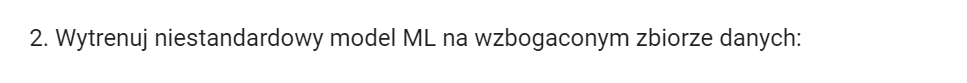

In [ ]:
python3 train_on_vertexai.py --project $PROJECT_ID  --bucket $BUCKET --region us-central1 --develop --cpuonly

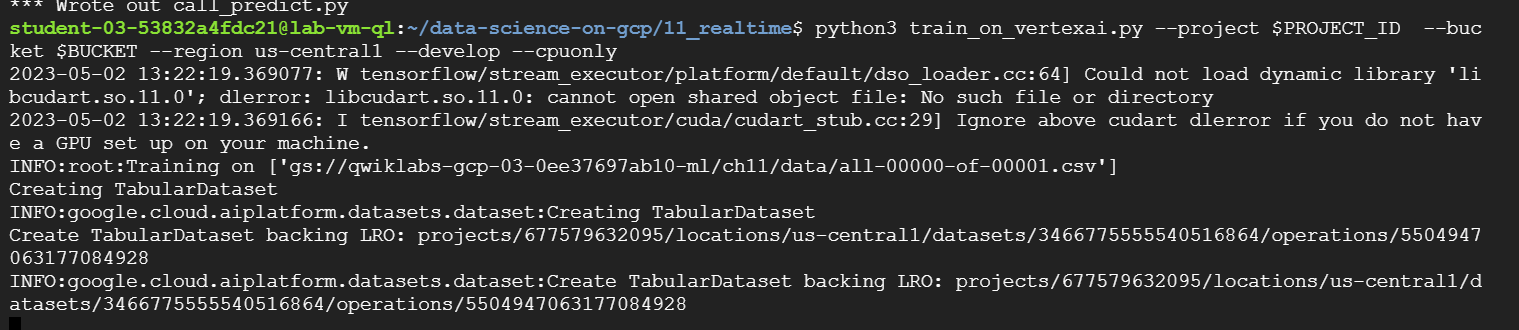

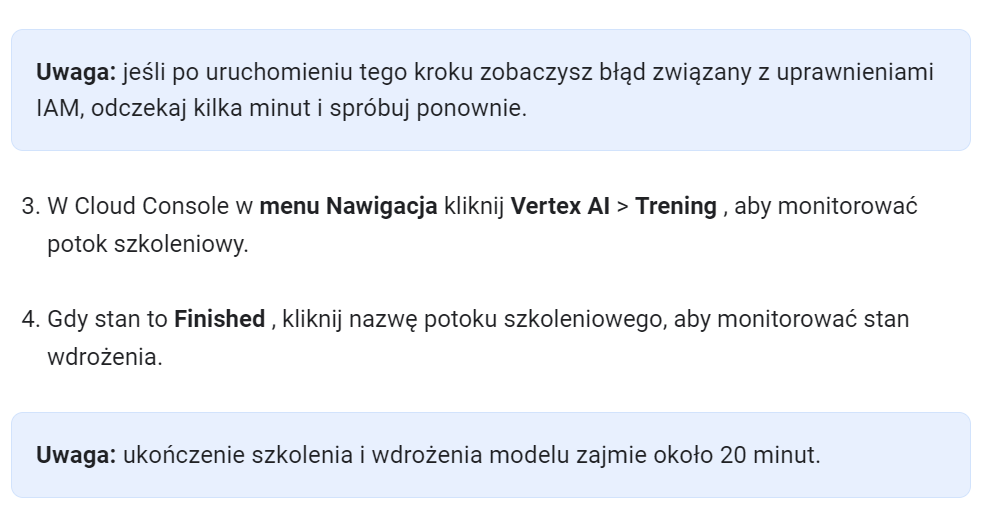

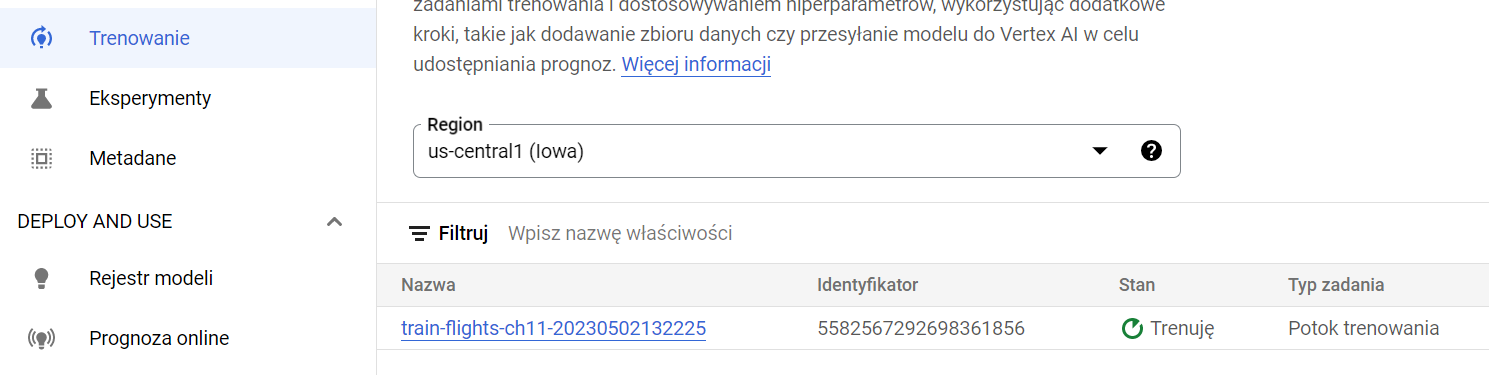

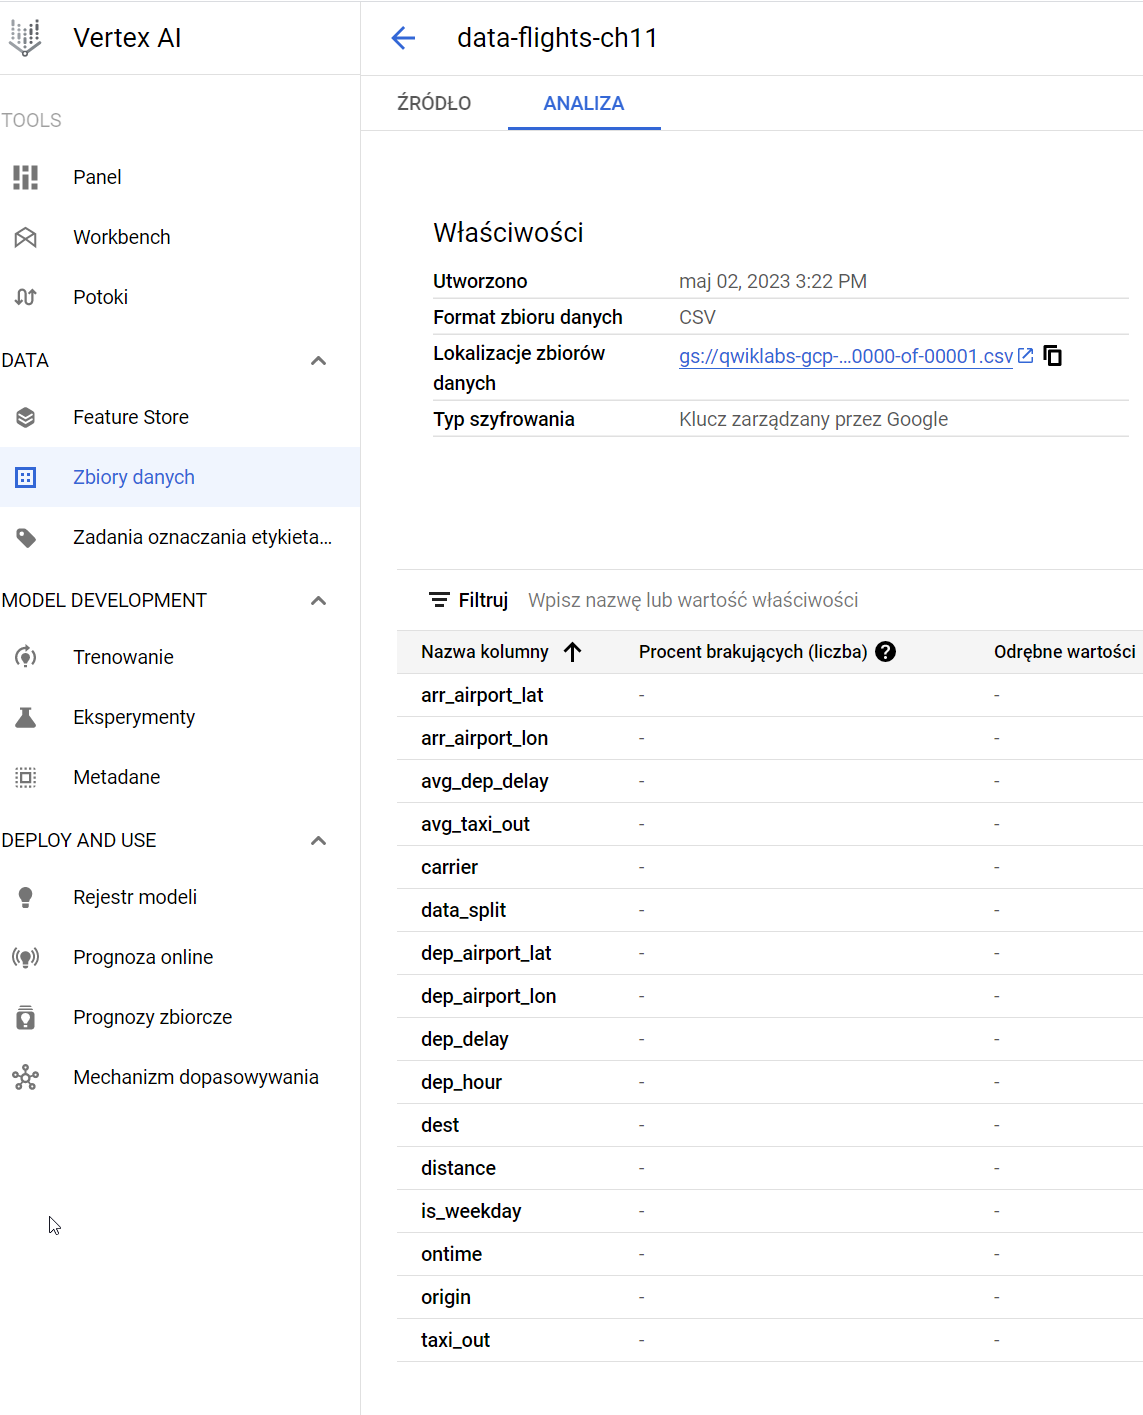

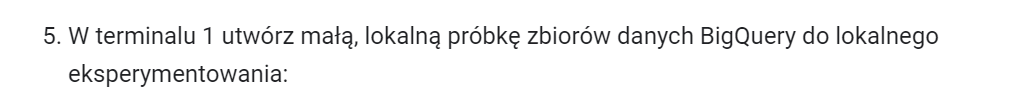

In [ ]:
bq query --nouse_legacy_sql --format=sparse \
    "SELECT EVENT_DATA FROM dsongcp.flights_simevents WHERE EVENT_TYPE = 'wheelsoff' AND EVENT_TIME BETWEEN '2015-03-01' AND '2015-03-02'" \
    | grep FL_DATE \
    > simevents_sample.json

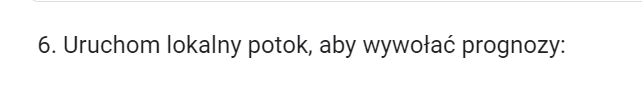

In [ ]:
python3 make_predictions.py --input local -p $PROJECT_ID

###`make_predictions.py`

In [ ]:
#!/usr/bin/env python3

# Copyright 2021 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import apache_beam as beam
import logging
import json
import os

from flightstxf import flights_transforms as ftxf


CSV_HEADER = 'event_time,dep_delay,taxi_out,distance,origin,dest,dep_hour,is_weekday,carrier,dep_airport_lat,dep_airport_lon,arr_airport_lat,arr_airport_lon,avg_dep_delay,avg_taxi_out,prob_ontime'


# class FlightsModelSharedInvoker(beam.DoFn):
#     # https://beam.apache.org/releases/pydoc/2.24.0/apache_beam.utils.shared.html
#     def __init__(self, shared_handle):
#         self._shared_handle = shared_handle
#
#     def process(self, input_data):
#         def create_endpoint():
#             from google.cloud import aiplatform
#             endpoint_name = 'flights-ch10'
#             endpoints = aiplatform.Endpoint.list(
#                 filter='display_name="{}"'.format(endpoint_name),
#                 order_by='create_time desc'
#             )
#             if len(endpoints) == 0:
#                 raise EnvironmentError("No endpoint named {}".format(endpoint_name))
#             logging.info("Found endpoint {}".format(endpoints[0]))
#             return endpoints[0]
#
#         # get already created endpoint if possible
#         endpoint = self._shared_handle.acquire(create_endpoint)
#
#         # call predictions and pull out probability
#         logging.info("Invoking ML model on {} flights".format(len(input_data)))
#         predictions = endpoint.predict(input_data).predictions
#         for idx, input_instance in enumerate(input_data):
#             result = input_instance.copy()
#             result['prob_ontime'] = predictions[idx][0]
#             yield result


class FlightsModelInvoker(beam.DoFn):
    def __init__(self):
        self.endpoint = None

    def setup(self):
        from google.cloud import aiplatform
        endpoint_name = 'flights-ch11'
        endpoints = aiplatform.Endpoint.list(
            filter='display_name="{}"'.format(endpoint_name),
            order_by='create_time desc'
        )
        if len(endpoints) == 0:
            raise EnvironmentError("No endpoint named {}".format(endpoint_name))
        logging.info("Found endpoint {}".format(endpoints[0]))
        self.endpoint = endpoints[0]

    def process(self, input_data):
        # call predictions and pull out probability
        logging.info("Invoking ML model on {} flights".format(len(input_data)))
        # drop inputs not needed by model
        features = [x.copy() for x in input_data]
        for f in features:
            f.pop('event_time')
        # call model
        predictions = self.endpoint.predict(features).predictions
        for idx, input_instance in enumerate(input_data):
            result = input_instance.copy()
            result['prob_ontime'] = predictions[idx][0]
            yield result


def run(project, bucket, region, source, sink):
    if source == 'local':
        logging.info('Running locally on small extract')
        argv = [
            '--project={0}'.format(project),
            '--runner=DirectRunner'
        ]
        flights_output = '/tmp/predictions'
    else:
        logging.info('Running in the cloud on full dataset input={}'.format(source))
        argv = [
            '--project={0}'.format(project),
            '--job_name=ch10predictions',
            '--save_main_session',
            '--staging_location=gs://{0}/flights/staging/'.format(bucket),
            '--temp_location=gs://{0}/flights/temp/'.format(bucket),
            '--setup_file=./setup.py',
            '--autoscaling_algorithm=THROUGHPUT_BASED',
            '--max_num_workers=8',
            '--region={}'.format(region),
            '--runner=DataflowRunner'
        ]
        if source == 'pubsub':
            logging.info("Turning on streaming. Cancel the pipeline from GCP console")
            argv += ['--streaming']
        flights_output = 'gs://{}/flights/ch11/predictions'.format(bucket)

    with beam.Pipeline(argv=argv) as pipeline:

        # read the event stream
        if source == 'local':
            input_file = './simevents_sample.json'
            logging.info("Reading from {} ... Writing to {}".format(input_file, flights_output))
            events = (
                    pipeline
                    | 'read_input' >> beam.io.ReadFromText(input_file)
                    | 'parse_input' >> beam.Map(lambda line: json.loads(line))
            )
        elif source == 'bigquery':
            input_query = ("SELECT EVENT_DATA FROM dsongcp.flights_simevents " +
                           "WHERE EVENT_TIME BETWEEN '2015-03-01' AND '2015-03-02'")
            logging.info("Reading from {} ... Writing to {}".format(input_query, flights_output))
            events = (
                    pipeline
                    | 'read_input' >> beam.io.ReadFromBigQuery(query=input_query, use_standard_sql=True)
                    | 'parse_input' >> beam.Map(lambda row: json.loads(row['EVENT_DATA']))
            )
        elif source == 'pubsub':
            input_topic = "projects/{}/topics/wheelsoff".format(project)
            logging.info("Reading from {} ... Writing to {}".format(input_topic, flights_output))
            events = (
                    pipeline
                    | 'read_input' >> beam.io.ReadFromPubSub(topic=input_topic,
                                                             timestamp_attribute='EventTimeStamp')
                    | 'parse_input' >> beam.Map(lambda s: json.loads(s))
            )
        else:
            logging.error("Unknown input type {}".format(source))
            return

        # events -> features.  See ./flights_transforms.py for the code shared between training & prediction
        features = ftxf.transform_events_to_features(events, for_training=False)

        # call model endpoint
        # shared_handle = beam.utils.shared.Shared()
        preds = (
                features
                | 'into_global' >> beam.WindowInto(beam.window.GlobalWindows())
                | 'batch_instances' >> beam.BatchElements(min_batch_size=1, max_batch_size=64)
                | 'model_predict' >> beam.ParDo(FlightsModelInvoker())
        )

        # write it out
        if sink == 'file':
            (preds
             | 'to_string' >> beam.Map(lambda f: ','.join([str(x) for x in f.values()]))
             | 'to_gcs' >> beam.io.textio.WriteToText(flights_output,
                                                      file_name_suffix='.csv', header=CSV_HEADER,
                                                      # workaround b/207384805
                                                      num_shards=1)
             )
        elif sink == 'bigquery':
            preds_schema = ','.join([
                'event_time:timestamp',
                'prob_ontime:float',
                'dep_delay:float',
                'taxi_out:float',
                'distance:float',
                'origin:string',
                'dest:string',
                'dep_hour:integer',
                'is_weekday:integer',
                'carrier:string',
                'dep_airport_lat:float,dep_airport_lon:float',
                'arr_airport_lat:float,arr_airport_lon:float',
                'avg_dep_delay:float',
                'avg_taxi_out:float',
            ])
            (preds
             | 'to_bigquery' >> beam.io.WriteToBigQuery(
                        'dsongcp.streaming_preds', schema=preds_schema,
                        # write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE,
                        create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                        method='STREAMING_INSERTS'
                    )
             )
        else:
            logging.error("Unknown output type {}".format(sink))
            return


if __name__ == '__main__':
    import argparse

    parser = argparse.ArgumentParser(description='Create training CSV file that includes time-aggregate features')
    parser.add_argument('-p', '--project', help='Project to be billed for Dataflow/BigQuery', required=True)
    parser.add_argument('-b', '--bucket', help='data will be read from written to gs://BUCKET/flights/ch11/')
    parser.add_argument('-r', '--region', help='Region to run Dataflow job. Choose the same region as your bucket.')
    parser.add_argument('-i', '--input', help='local, bigquery OR pubsub', required=True)
    parser.add_argument('-o', '--output', help='file, bigquery OR bigtable', default='file')

    logging.getLogger().setLevel(logging.INFO)
    args = vars(parser.parse_args())

    if args['input'] != 'local':
        if not args['bucket'] or not args['project'] or not args['region']:
            print("Project, Bucket, Region are needed in order to run on the cloud on full dataset.")
            parser.print_help()
            parser.exit()

    run(project=args['project'], bucket=args['bucket'], region=args['region'],
        source=args['input'], sink=args['output'])

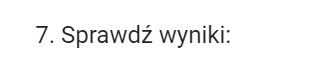

In [ ]:
cat /tmp/predictions*

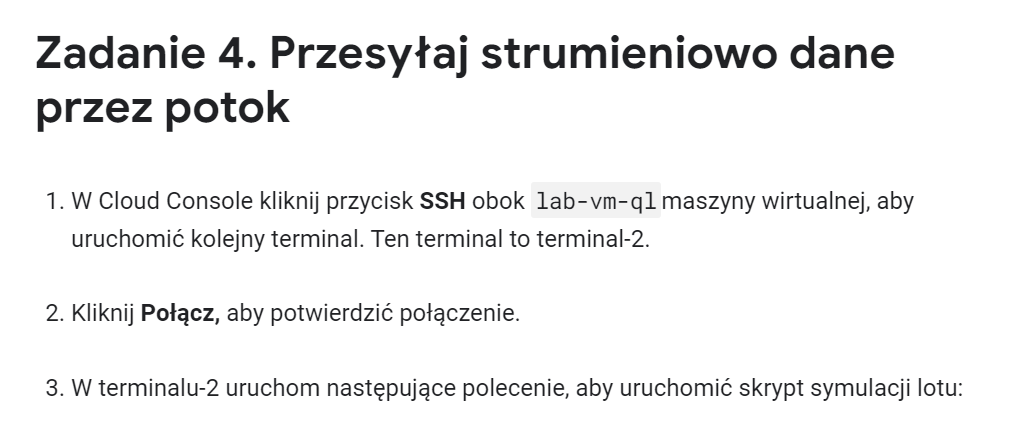

In [ ]:
cd  ~/data-science-on-gcp/04_streaming/simulate
export PROJECT_ID=$(gcloud info --format='value(config.project)')
python3 ./simulate.py --startTime '2015-02-01 00:00:00 UTC' --endTime '2015-03-03 00:00:00 UTC' --speedFactor=30 --project $PROJECT_ID

###`simulate.py`

In [ ]:
#!/usr/bin/env python3

# Copyright 2016 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import time
import pytz
import logging
import argparse
import datetime
import google.cloud.pubsub_v1 as pubsub # Use v1 of the API
import google.cloud.bigquery as bq

TIME_FORMAT = '%Y-%m-%d %H:%M:%S %Z'
RFC3339_TIME_FORMAT = '%Y-%m-%dT%H:%M:%S-00:00'

def publish(publisher, topics, allevents, notify_time):
   timestamp = notify_time.strftime(RFC3339_TIME_FORMAT)
   for key in topics:  # 'departed', 'arrived', etc.
      topic = topics[key]
      events = allevents[key]
      # the client automatically batches
      logging.info('Publishing {} {} till {}'.format(len(events), key, timestamp))
      for event_data in events:
          publisher.publish(topic, event_data.encode(), EventTimeStamp=timestamp)

def notify(publisher, topics, rows, simStartTime, programStart, speedFactor):
   # sleep computation
   def compute_sleep_secs(notify_time):
        time_elapsed = (datetime.datetime.utcnow() - programStart).total_seconds()
        sim_time_elapsed = (notify_time - simStartTime).total_seconds() / speedFactor
        to_sleep_secs = sim_time_elapsed - time_elapsed
        return to_sleep_secs

   tonotify = {}
   for key in topics:
     tonotify[key] = list()

   for row in rows:
       event_type, notify_time, event_data = row

       # how much time should we sleep?
       if compute_sleep_secs(notify_time) > 1:
          # notify the accumulated tonotify
          publish(publisher, topics, tonotify, notify_time)
          for key in topics:
             tonotify[key] = list()

          # recompute sleep, since notification takes a while
          to_sleep_secs = compute_sleep_secs(notify_time)
          if to_sleep_secs > 0:
             logging.info('Sleeping {} seconds'.format(to_sleep_secs))
             time.sleep(to_sleep_secs)
       tonotify[event_type].append(event_data)

   # left-over records; notify again
   publish(publisher, topics, tonotify, notify_time)


if __name__ == '__main__':
   parser = argparse.ArgumentParser(description='Send simulated flight events to Cloud Pub/Sub')
   parser.add_argument('--startTime', help='Example: 2015-05-01 00:00:00 UTC', required=True)
   parser.add_argument('--endTime', help='Example: 2015-05-03 00:00:00 UTC', required=True)
   parser.add_argument('--project', help='your project id, to create pubsub topic', required=True)
   parser.add_argument('--speedFactor', help='Example: 60 implies 1 hour of data sent to Cloud Pub/Sub in 1 minute', required=True, type=float)
   parser.add_argument('--jitter', help='type of jitter to add: None, uniform, exp  are the three options', default='None')

   # set up BigQuery bqclient
   logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)
   args = parser.parse_args()
   bqclient = bq.Client(args.project)
   bqclient.get_table('dsongcp.flights_simevents')  # throws exception on failure

   # jitter?
   if args.jitter == 'exp':
      jitter = 'CAST (-LN(RAND()*0.99 + 0.01)*30 + 90.5 AS INT64)'
   elif args.jitter == 'uniform':
      jitter = 'CAST(90.5 + RAND()*30 AS INT64)'
   else:
      jitter = '0'


   # run the query to pull simulated events
   querystr = """
SELECT
  EVENT_TYPE,
  TIMESTAMP_ADD(EVENT_TIME, INTERVAL @jitter SECOND) AS NOTIFY_TIME,
  EVENT_DATA
FROM
  dsongcp.flights_simevents
WHERE
  EVENT_TIME >= @startTime
  AND EVENT_TIME < @endTime
ORDER BY
  EVENT_TIME ASC
"""
   job_config = bq.QueryJobConfig(
       query_parameters=[
           bq.ScalarQueryParameter("jitter", "INT64", jitter),
           bq.ScalarQueryParameter("startTime", "TIMESTAMP", args.startTime),
           bq.ScalarQueryParameter("endTime", "TIMESTAMP", args.endTime),
       ]
   )
   rows = bqclient.query(querystr, job_config=job_config)

   # create one Pub/Sub notification topic for each type of event
   publisher = pubsub.PublisherClient()
   topics = {}
   for event_type in ['wheelsoff', 'arrived', 'departed']:
       topics[event_type] = publisher.topic_path(args.project, event_type)
       try:
           publisher.get_topic(topic=topics[event_type])
           logging.info("Already exists: {}".format(topics[event_type]))
       except:
           logging.info("Creating {}".format(topics[event_type]))
           publisher.create_topic(name=topics[event_type])


   # notify about each row in the dataset
   programStartTime = datetime.datetime.utcnow()
   simStartTime = datetime.datetime.strptime(args.startTime, TIME_FORMAT).replace(tzinfo=pytz.UTC)
   logging.info('Simulation start time is {}'.format(simStartTime))
   notify(publisher, topics, rows, simStartTime, programStartTime, args.speedFactor)

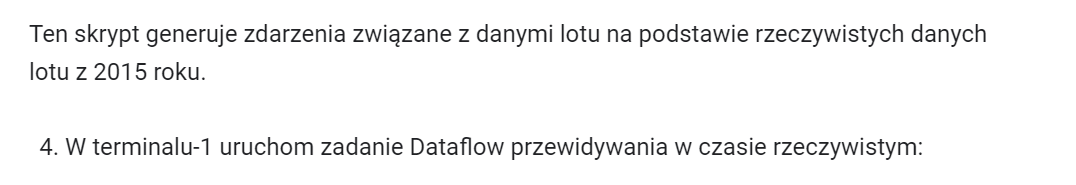

In [ ]:
python3 make_predictions.py --input pubsub --output bigquery --project $PROJECT_ID --bucket $BUCKET --region us-central1

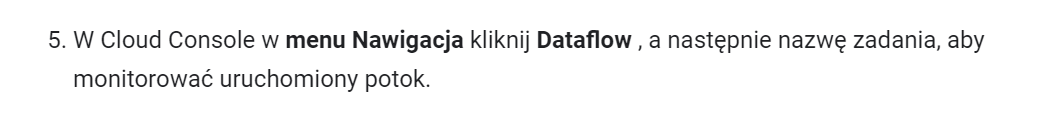

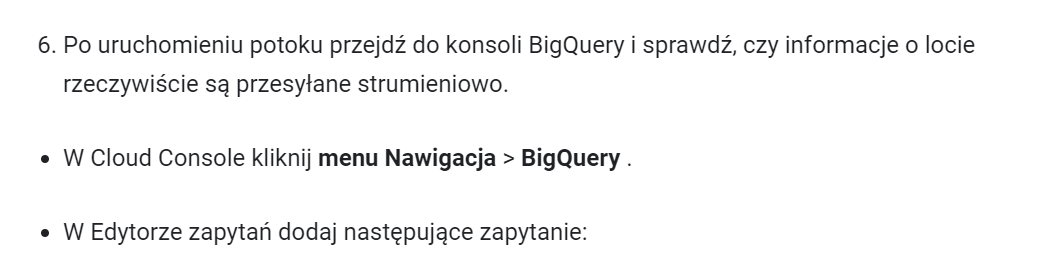

In [ ]:
%%bigquery

SELECT * FROM dsongcp.streaming_preds ORDER BY event_time DESC LIMIT 10

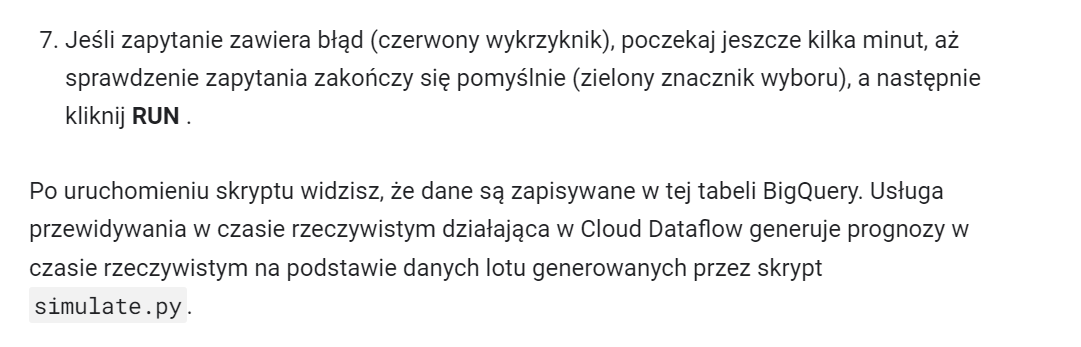